# Building with the YG3 API and CLM (Concentrated Language Models)

##Customer Support Agent - ReAct Pattern Demo

### The #1 Most Popular AI Agent Pattern

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/)

---

### Why This Matters

According to the **LangChain State of AI Agents Report 2025**:
- **45.8%** of AI agents are used for customer service
- **58%** handle research and information retrieval  
- Tool calling usage jumped from **0.5% → 21.9%** in one year
- **78%** of companies plan to deploy agents to production

### What You'll Learn

1. How to build a **ReAct (Reasoning + Acting)** agent
2. How agents use **tools** to take actions
3. How to integrate with the **Elysia API** (OpenAI-compatible)
4. Real business use case: Customer support automation

###  What This Agent Can Do

- 🔍 Search a knowledge base for policies
- 📦 Check order status and tracking information
- 💬 Provide helpful, context-aware responses
- 🤖 Reason about what tools to use and when

---

## Step 1: Installation

First, let's install the required packages. This only takes about 10 second.

In [ ]:
# Install required packages
!pip install openai gradio -q

print("✅ Installation complete!")

✅ Installation complete!


## Step 2: Configure YG3 CLM API

**Important:** Replace `"your-api-key-here"` with your actual YG3 API key!

Get your API key at: [https://app.yg3.ai](https://app.yg3.ai)
Navigate to: [API Key Dashboard](https://app.yg3.ai/api-keys)

Your first 10k tokens are free!
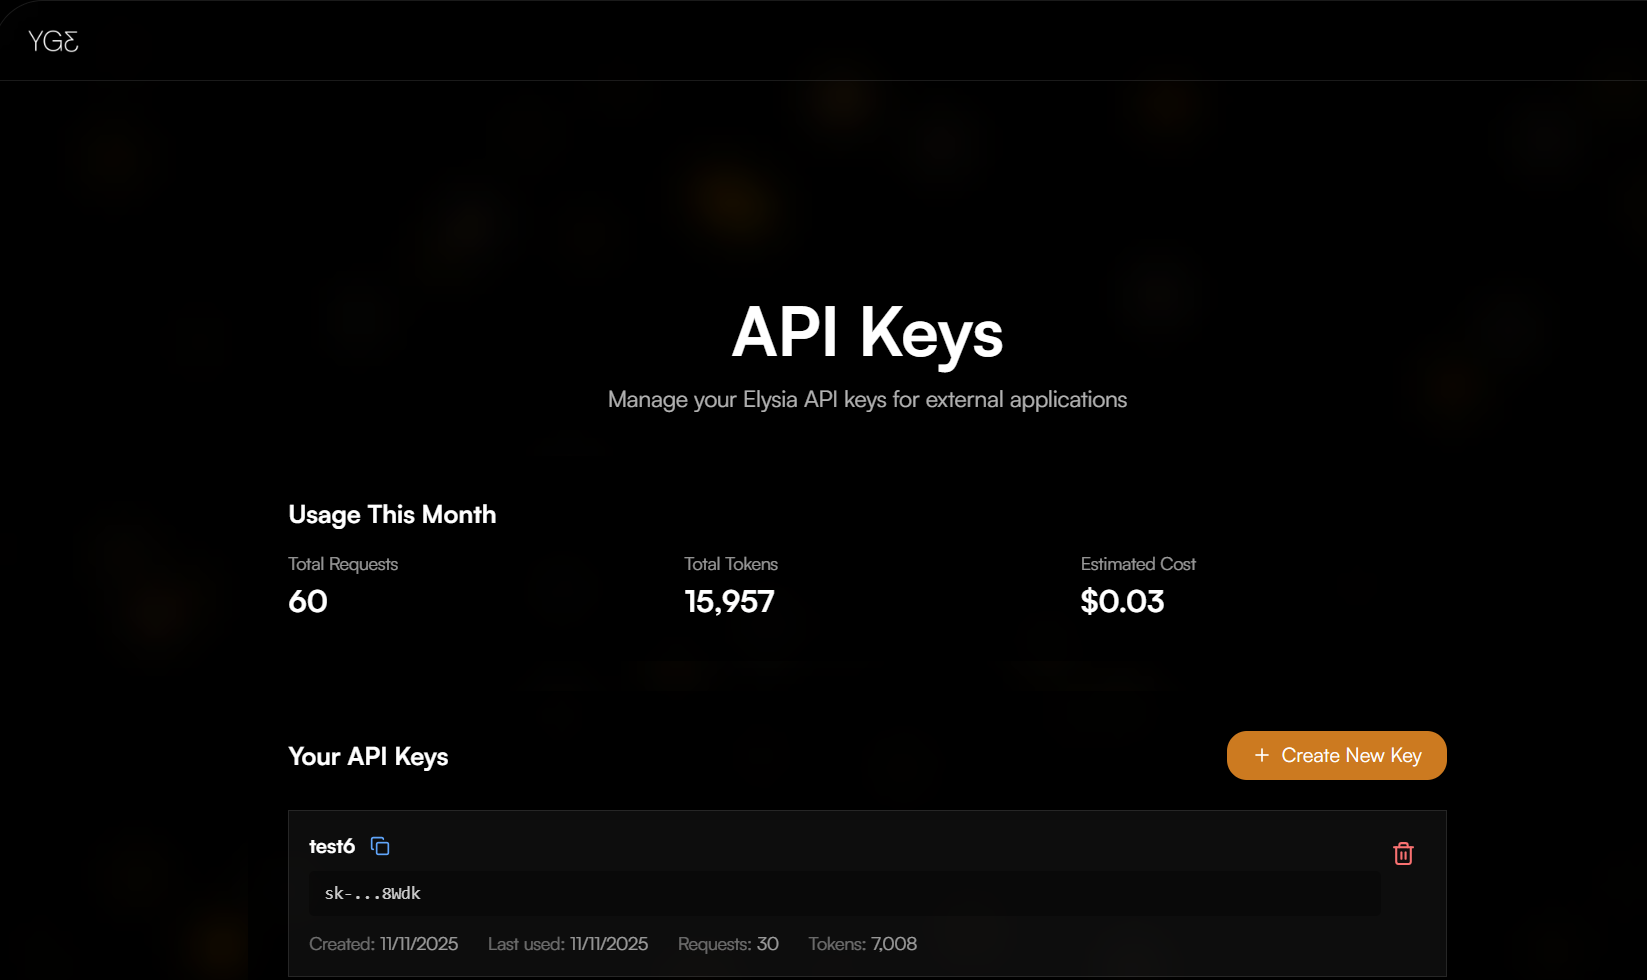


In [ ]:
# 🔑 API Configuration
from google.colab import userdata

API_KEY = 'YOUR_API_KEY_HERE'


BASE_URL = "https://elysia-api.ngrok.io/api/public/v1"

print("✅ Configuration set!")
print(f"📡 Base URL: {BASE_URL}")
print(f"🔐 API Key: {'*' * 20 if API_KEY != 'your-api-key-here' else '❌ NOT SET'}")

## Step 3: Demo Data Setup 📊

In a real production system, this would be:
- **Knowledge Base** → Vector database (Pinecone, Weaviate)
- **Orders** → CRM/ERP system (Shopify, Salesforce)

For this demo, we're using simple Python dictionaries.

In [ ]:
import json
from openai import OpenAI
import re

# Knowledge Base - Company Policies
KNOWLEDGE_BASE = {
    "return_policy": {
        "title": "Return Policy",
        "content": "You can return items within 30 days of purchase. Items must be unused and in original packaging. Refunds are processed within 5-7 business days."
    },
    "shipping": {
        "title": "Shipping Information",
        "content": "Free shipping on orders over $50. Standard shipping takes 3-5 business days. Express shipping is $15 and takes 1-2 business days."
    },
    "warranty": {
        "title": "Warranty Coverage",
        "content": "All products come with a 1-year manufacturer's warranty. Extended warranties available at checkout."
    },
    "payment": {
        "title": "Payment Methods",
        "content": "We accept Visa, Mastercard, Amex, PayPal, Apple Pay, and Google Pay."
    }
}

# Order Database - Customer Orders
ORDERS = {
    "ORD-12345": {
        "status": "shipped",
        "items": ["Wireless Headphones", "Phone Case"],
        "total": "$89.99",
        "tracking": "1Z999AA10123456784",
        "carrier": "UPS",
        "estimated_delivery": "Nov 14, 2025"
    },
    "ORD-67890": {
        "status": "processing",
        "items": ["Laptop Stand", "USB-C Cable"],
        "total": "$65.00",
        "tracking": None,
        "estimated_delivery": "Nov 16, 2025"
    },
    "ORD-54321": {
        "status": "delivered",
        "items": ["Mechanical Keyboard"],
        "total": "$129.99",
        "tracking": "1Z999AA10987654321",
        "carrier": "FedEx",
        "estimated_delivery": "Nov 9, 2025"
    }
}

print("✅ Demo data loaded!")
print(f"📚 Knowledge Base: {len(KNOWLEDGE_BASE)} topics")
print(f"📦 Orders: {len(ORDERS)} test orders")

✅ Demo data loaded!
📚 Knowledge Base: 4 topics
📦 Orders: 3 test orders


## Step 4: Define Tools 🔧

**Tools** are functions the agent can call to take actions. This is what makes it "agentic"!

Our agent has 2 tools:
1. `search_knowledge_base` - Search for policies
2. `check_order_status` - Look up orders

In [ ]:
def search_knowledge_base(topic: str) -> dict:
    """Search the knowledge base for information"""
    topic_lower = topic.lower()

    for key, data in KNOWLEDGE_BASE.items():
        if key in topic_lower or any(word in topic_lower for word in key.split('_')):
            return {
                "success": True,
                "tool": "search_knowledge_base",
                "result": data
            }

    return {
        "success": False,
        "result": "No information found."
    }

def check_order_status(order_id: str) -> dict:
    """Look up order information"""
    order_id_upper = order_id.upper()

    if order_id_upper in ORDERS:
        return {
            "success": True,
            "tool": "check_order_status",
            "order_id": order_id_upper,
            "result": ORDERS[order_id_upper]
        }
    else:
        return {
            "success": False,
            "result": f"Order {order_id} not found."
        }

print("✅ Tools defined!")
print("\n🔧 Available Tools:")
print("  1. search_knowledge_base(topic)")
print("  2. check_order_status(order_id)")

✅ Tools defined!

🔧 Available Tools:
  1. search_knowledge_base(topic)
  2. check_order_status(order_id)


## Step 5: Build the ReAct Agent

### What is ReAct?

**ReAct = Reasoning + Acting**

The agent follows this pattern:
1. **Thought** - Analyze the question
2. **Action** - Decide which tool to use (if any)
3. **Observation** - Get results from the tool
4. **Response** - Answer the customer

This is more powerful than simple prompt chains because the agent can dynamically decide what to do!

In [ ]:
def run_agent(customer_message: str, api_key: str = API_KEY, verbose: bool = True) -> tuple:
    """
    Run the ReAct agent
    Returns: (final_answer, reasoning_steps)
    """

    if not api_key or api_key == "your-api-key-here":
        return "⚠️ Please set your API key!", []

    # Initialize the API client
    client = OpenAI(api_key=api_key, base_url=BASE_URL)

    # System prompt that defines how the agent should behave
    system_prompt = system_prompt = """You are a customer support agent. This specific company's policies, prices, and order information aren't known to you so you look them up using tools.

Available tools:
1. SEARCH_KB(topic) - Look up this company's policies (returns, shipping, warranty, payment)
2. CHECK_ORDER(order_id) - Look up order information from this company's system

When to use tools:
- Customer asks about THIS company's policies → Use SEARCH_KB
- Customer asks about THEIR order status → Use CHECK_ORDER
- Customer asks general questions you can answer → Answer directly

Tool call format (use exactly):
TOOL_CALL: TOOL_NAME(parameter)

Examples:
- "What's your return policy?" → TOOL_CALL: SEARCH_KB(return_policy)
- "How long does shipping take?" → TOOL_CALL: SEARCH_KB(shipping)
- "Check order ORD-12345" → TOOL_CALL: CHECK_ORDER(ORD-12345)
- "What does tracking number mean?" → Answer directly (general knowledge)

After getting tool results, provide a helpful, friendly answer to the customer. Please do not use your name 'Elysia' or preface answers with 'User'"""

    messages = [
        {"role": "system", "content": system_prompt},
        {"role": "user", "content": customer_message}
    ]

    steps = []
    max_iterations = 3

    for iteration in range(max_iterations):
        if verbose:
            print(f"\n{'='*60}")
            print(f"🔄 Iteration {iteration + 1}")
            print(f"{'='*60}")

        # Get agent's response
        response = client.chat.completions.create(
            model="elysia",
            messages=messages,
            max_tokens=300
        )

        agent_response = response.choices[0].message.content

        if verbose:
            print(f"\n🤖 Agent Response:")
            print(agent_response)

        steps.append(f"**Step {iteration + 1}:** {agent_response[:150]}...")

        # Check for tool call
        if "TOOL_CALL:" in agent_response:
            # Parse: TOOL_CALL: TOOL_NAME(param)
            match = re.search(r'TOOL_CALL:\s*(\w+)\(([^)]+)\)', agent_response)

            if match:
                tool_name = match.group(1)
                parameter = match.group(2).strip()

                if verbose:
                    print(f"\n🔧 Tool Call: {tool_name}({parameter})")

                # Execute tool
                if tool_name == "SEARCH_KB":
                    tool_result = search_knowledge_base(parameter)
                elif tool_name == "CHECK_ORDER":
                    tool_result = check_order_status(parameter)
                else:
                    tool_result = {"success": False, "result": "Unknown tool"}

                if verbose:
                    print(f"\n📊 Tool Result:")
                    print(json.dumps(tool_result, indent=2))

                steps.append(f"**Tool Used:** {tool_name}({parameter})")
                steps.append(f"**Result:** {json.dumps(tool_result, indent=2)[:100]}...")

                # Add to conversation
                messages.append({"role": "assistant", "content": agent_response})
                messages.append({
                    "role": "user",
                    "content": f"Tool result: {json.dumps(tool_result)}\n\nNow answer the customer."
                })
            else:
                return agent_response, steps
        else:
            # Final answer
            if verbose:
                print(f"\n✅ Final Answer Generated!")
            return agent_response, steps

    return agent_response, steps

print("✅ Agent function ready!")

✅ Agent function ready!


## Step 6: Test the Agent

Let's test with some real customer questions. Watch how the agent:
1. Analyzes the question
2. Decides which tool to use
3. Gets the information
4. Formulates a helpful answer

In [ ]:
# Test 1: Knowledge Base Query
print("\n" + "="*70)
print("🧪 TEST 1: Asking about return policy")
print("="*70)

question1 = "What's your return policy?"
print(f"\n👤 Customer: {question1}")

answer1, steps1 = run_agent(question1, verbose=True)

print(f"\n" + "="*70)
print("📝 FINAL ANSWER:")
print("="*70)
print(answer1)


🧪 TEST 1: Asking about return policy

👤 Customer: What's your return policy?

🔄 Iteration 1

🤖 Agent Response:
TOOL_CALL: SEARCH_KB(return_policy)
Our return policy is quite straightforward. We accept returns within 30 days of purchase, provided the item is in its original condition and packaging. If you'd like more information, please let me know!

🔧 Tool Call: SEARCH_KB(return_policy)

📊 Tool Result:
{
  "success": true,
  "tool": "search_knowledge_base",
  "result": {
    "title": "Return Policy",
    "content": "You can return items within 30 days of purchase. Items must be unused and in original packaging. Refunds are processed within 5-7 business days."
  }
}

🔄 Iteration 2

🤖 Agent Response:
The return policy is quite simple. You have 30 days from the date of purchase to return your items, as long as they remain unused and in their original packaging. Refunds are processed within 5-7 business days after we receive your returned items. If you have any other questions or need fur

In [ ]:
# Test 2: Order Status Check
print("\n" + "="*70)
print("🧪 TEST 2: Checking order status")
print("="*70)

question2 = "Can you check my order ORD-12345?"
print(f"\n👤 Customer: {question2}")

answer2, steps2 = run_agent(question2, verbose=True)

print(f"\n" + "="*70)
print("📝 FINAL ANSWER:")
print("="*70)
print(answer2)


🧪 TEST 2: Checking order status

👤 Customer: Can you check my order ORD-12345?

🔄 Iteration 1

🤖 Agent Response:
TOOL_CALL: CHECK_ORDER(ORD-12345) Checking your order status now. Please wait a moment.

🔧 Tool Call: CHECK_ORDER(ORD-12345)

📊 Tool Result:
{
  "success": true,
  "tool": "check_order_status",
  "order_id": "ORD-12345",
  "result": {
    "status": "shipped",
    "items": [
      "Wireless Headphones",
      "Phone Case"
    ],
    "total": "$89.99",
    "tracking": "1Z999AA10123456784",
    "carrier": "UPS",
    "estimated_delivery": "Nov 14, 2025"
  }
}

🔄 Iteration 2

🤖 Agent Response:
Your order ORD-12345 has been shipped! It includes Wireless Headphones and a Phone Case, for a total of $89.99. Your tracking number is 1Z999AA10123456784 and it's being delivered by UPS with an estimated delivery date of Nov 14, 2025. If you have any further questions or concerns about your order, please let me know!

✅ Final Answer Generated!

📝 FINAL ANSWER:
Your order ORD-12345 has bee

In [ ]:
# Test 3: Complex Query
print("\n" + "="*70)
print("🧪 TEST 3: Multiple questions")
print("="*70)

question3 = "How long does shipping take and is it free?"
print(f"\n👤 Customer: {question3}")

answer3, steps3 = run_agent(question3, verbose=True)

print(f"\n" + "="*70)
print("📝 FINAL ANSWER:")
print("="*70)
print(answer3)


🧪 TEST 3: Multiple questions

👤 Customer: How long does shipping take and is it free?

🔄 Iteration 1

🤖 Agent Response:
TOOL_CALL: SEARCH_KB(shipping)
Shipping typically takes 3-5 business days, and it's free for orders over $50. Your order total and estimated shipping time will be displayed during checkout.

🔧 Tool Call: SEARCH_KB(shipping)

📊 Tool Result:
{
  "success": true,
  "tool": "search_knowledge_base",
  "result": {
    "title": "Shipping Information",
    "content": "Free shipping on orders over $50. Standard shipping takes 3-5 business days. Express shipping is $15 and takes 1-2 business days."
  }
}

🔄 Iteration 2

🤖 Agent Response:
Shipping typically takes 3-5 business days, and it's free for orders over $50. Your order total and estimated shipping time will be displayed during checkout.

✅ Final Answer Generated!

📝 FINAL ANSWER:
Shipping typically takes 3-5 business days, and it's free for orders over $50. Your order total and estimated shipping time will be displayed 

## Step 7: Launch Interactive UI

Now let's create a beautiful Gradio interface so you can interact with the agent.

This will:
- Create a web interface
- Give you a public URL to share
- Show the agent's reasoning process
- Let you try different queries

In [ ]:
import gradio as gr

def create_demo():
    """Create beautiful Gradio interface"""

    custom_css = """
    .gradio-container {
        font-family: 'Arial', sans-serif;
    }
    .gr-button-primary {
        background: linear-gradient(90deg, #667eea 0%, #764ba2 100%) !important;
    }
    """

    with gr.Blocks(css=custom_css, title="AI Customer Support") as demo:

        gr.Markdown("""
        # 🤖 Customer Support Agent Demo
        ### The #1 Most Popular AI Agent Pattern in 2025

        **ReAct Pattern:** Reasoning + Acting with Tools

        This agent can:
        - 🔍 Search knowledge base for policies
        - 📦 Check order status and tracking
        - 💬 Provide helpful customer support 24/7
        """)

        with gr.Row():
            with gr.Column(scale=2):
                customer_input = gr.Textbox(
                    label="💬 Customer Message",
                    placeholder="Ask about returns, shipping, or check an order...",
                    lines=3
                )

                gr.Markdown("**Quick Examples:**")
                with gr.Row():
                    ex1 = gr.Button("📋 Return Policy", size="sm")
                    ex2 = gr.Button("📦 Shipping Info", size="sm")
                    ex3 = gr.Button("🔍 Check Order", size="sm")

                submit_btn = gr.Button("🚀 Run Agent", variant="primary", size="lg")

            with gr.Column(scale=1):
                gr.Markdown("""
                ### 📊 Demo Info

                **Test Orders:**
                - ORD-12345 (Shipped)
                - ORD-67890 (Processing)
                - ORD-54321 (Delivered)

                **Business Impact:**
                - 60-80% automation
                - 70% faster responses
                - 40% cost reduction
                - 24/7 availability
                """)

        gr.Markdown("---\n## 🎯 Agent Response")

        answer_output = gr.Markdown(label="Answer")

        with gr.Accordion("🔍 View Reasoning Process", open=False):
            steps_output = gr.Markdown()

        gr.Markdown("""
        ---
        ### 📈 2025 Statistics

        | Metric | Value |
        |--------|-------|
        | Customer Service Agents | 45.8% |
        | Tool Usage Growth | 0.5% → 21.9% |
        | Companies with Plans | 78% |
        | Average Cost Savings | 40% |
        """)

        # Event handlers
        def run_and_display(message):
            answer, steps = run_agent(message, verbose=False)
            steps_text = "\n\n".join(steps) if steps else "No steps recorded"
            return answer, steps_text

        submit_btn.click(
            fn=run_and_display,
            inputs=[customer_input],
            outputs=[answer_output, steps_output]
        )

        ex1.click(lambda: "What's your return policy?", outputs=customer_input)
        ex2.click(lambda: "How long does shipping take?", outputs=customer_input)
        ex3.click(lambda: "Check order ORD-12345", outputs=customer_input)

    return demo

# Launch!
print("\n" + "="*70)
print("🚀 Launching Gradio Interface...")
print("="*70)
print("\n💡 A public URL will be generated that you can share!")
print("\n")

demo = create_demo()
demo.launch(
    share=True,  # Creates shareable public link
    debug=True
)


🚀 Launching Gradio Interface...

💡 A public URL will be generated that you can share!


Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://2f79f200842d2e7326.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://2f79f200842d2e7326.gradio.live


## Key Takeaways

### What You Just Built:

A **ReAct agent** that reasons and acts  
**Tool calling** to access real data  
**Customer support automation** (the #1 use case)  
**OpenAI-compatible API** integration  

### Why This Pattern Dominates 2025:

1. **Proven Results** - 45.8% of agents use this for customer service
2. **Flexible** - Easy to add new tools and capabilities
3. **Scalable** - Handle unlimited customers 24/7
4. **Cost-Effective** - 40% reduction in support costs

### Next Steps:

🔧 **Extend the Agent:**
- Add more tools (email, SMS, CRM integration)
- Connect to real databases
- Add conversation memory
- Implement human handoff

**Scale to Production:**
- Deploy with LangChain/LangGraph
- Add monitoring and analytics
- Implement rate limiting
- Add authentication

**Learn More:**
- [LangChain State of AI Agents 2025](https://www.langchain.com/stateofaiagents)
- [ReAct: Synergizing Reasoning and Acting in Language Models](https://arxiv.org/abs/2210.03629)
- [YG3 Platform](https://app.yg3.ai)
- [YG3 CLM API](https://colab.research.google.com/drive/1fSB4HMGpgtpmTbU-GhtmvKWuZza_CuPv#scrollTo=3kPgyHyWBsmV)

---

###  Share Your Results

Made something cool? Share it with:
- **Gradio's public link** (automatically created when you run the last cell)
- **Screenshot** your results
- **Fork and customize** this notebook

**Remember:** This is the #1 most popular business agent pattern in 2025 for a reason! 🚀

---